In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

small_dataset = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
small_dataset_dir = '/content/drive/MyDrive/UofT/Third Year/Summer/APS360/APS360 Project - Group 7/Code/OCT_split_NEWDATA' ## change this based on your own google drive directory
#small_dataset_dir = '/content/drive/MyDrive/Third Year/Summer/APS360/APS360 Project - Group 7/Code/small_dataset' ## change this based on your own google drive directory
#small_dataset_dir = '/content/drive/MyDrive/APS360 Project - Group 7/Code/small_dataset'

In [ ]:
def num_images(dir, folders):
    print(f"Number of images in each folder:")
    for folder in folders:
        path = os.path.join(dir, folder)
        if os.path.isdir(path):
            num_files = len(os.listdir(path))
            print(f"{folder}: {num_files}")
        else:
            print(f"Folder '{folder}' does not exist in the dataset directory.")

In [ ]:
num_images(small_dataset_dir, small_dataset)

Number of images in each folder:
CNV: 50
DME: 50
DRUSEN: 50
NORMAL: 50


In [ ]:
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision import models, transforms, datasets
from torch import nn

resnet_model = models.resnet152(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1]) # remove last classification layers
resnet_model.to(device)
resnet_model.eval()

In [ ]:
from PIL import Image
import cv2
from skimage.feature import local_binary_pattern  # for texture descriptors

def extract_texture_and_edges(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # edge detection using Sobel filter, https://how.dev/answers/sobel-operator-in-digital-image-processing
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Sobel in x-direction
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Sobel in y-direction
    edges = np.hypot(sobel_x, sobel_y)  # combine gradients

    # https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_local_binary_pattern.html
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')  # texture descriptors using Uniform Local Binary Pattern (LBP)

    edges_flat = edges.flatten()
    lbp_flat = lbp.flatten()

    combined_features = np.concatenate((edges_flat, lbp_flat), axis=0) # combine all features
    return combined_features

def extract_features(image_path, model, transform):
    image = Image.open(image_path).convert('RGB') # convert to rgb because resnet works with rgb
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        features = model(image)  # extract features from resnet
        features = features.view(features.size(0), -1)  # flatten to vector
    return features.cpu().numpy() # convert to numpy for svm


def extract_combined_features(image_path, resnet_model, transform):
    resnet_features = extract_features(image_path, resnet_model, transform)
    texture_edge_features = extract_texture_and_edges(image_path)

    # combine features (flatten resnet + texture/edge)
    combined_features = np.concatenate((resnet_features.flatten(), texture_edge_features), axis=0)
    return combined_features

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization for resnet
])

dataset = datasets.ImageFolder(small_dataset_dir, transform=data_transform)

In [ ]:
features = []
labels = []

# extract features in batches to save RAM
batch_size = 16
diseases = os.listdir(small_dataset_dir)

for disease in diseases:
    disease_dir = os.path.join(small_dataset_dir, disease)

    image_paths = [os.path.join(disease_dir, img) for img in os.listdir(disease_dir)]

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]

        batch_features = []
        batch_labels = []

        for image_path in batch_paths:
            resnet_feature = extract_features(image_path, resnet_model, data_transform)
            texture_edge_feature = extract_texture_and_edges(image_path)

            combined_features = np.concatenate((resnet_feature.flatten(), texture_edge_feature), axis=0)
            batch_features.append(combined_features)
            batch_labels.append(disease)

        features.extend(batch_features)
        labels.extend(batch_labels)

        torch.cuda.empty_cache()

features = np.array(features)
labels = np.array(labels)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42) # split features and labels into 70% training and 30% testing

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced') # rbf based on proposal

In [ ]:
svm_rbf.fit(X_train_pca, y_train)# train SVM

SVC(C=1, class_weight='balanced')

In [ ]:
y_pred = svm_rbf.predict(X_test_pca)

In [ ]:
# accuracy test

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.2333


Confusion Matrix:
[[14  0  0  0]
 [11  0  0  4]
 [18  0  0  2]
 [11  0  0  0]]


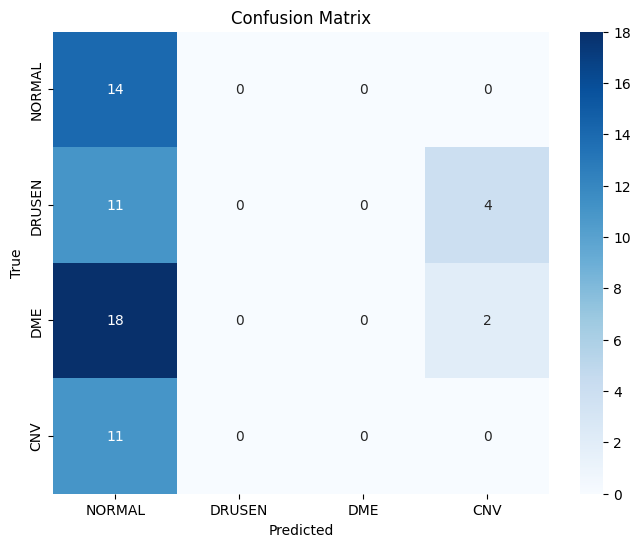

In [ ]:
# confusion matrix test

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=diseases, yticklabels=diseases)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, target_names=diseases)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.26      1.00      0.41        14
      DRUSEN       0.00      0.00      0.00        15
         DME       0.00      0.00      0.00        20
         CNV       0.00      0.00      0.00        11

    accuracy                           0.23        60
   macro avg       0.06      0.25      0.10        60
weighted avg       0.06      0.23      0.10        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


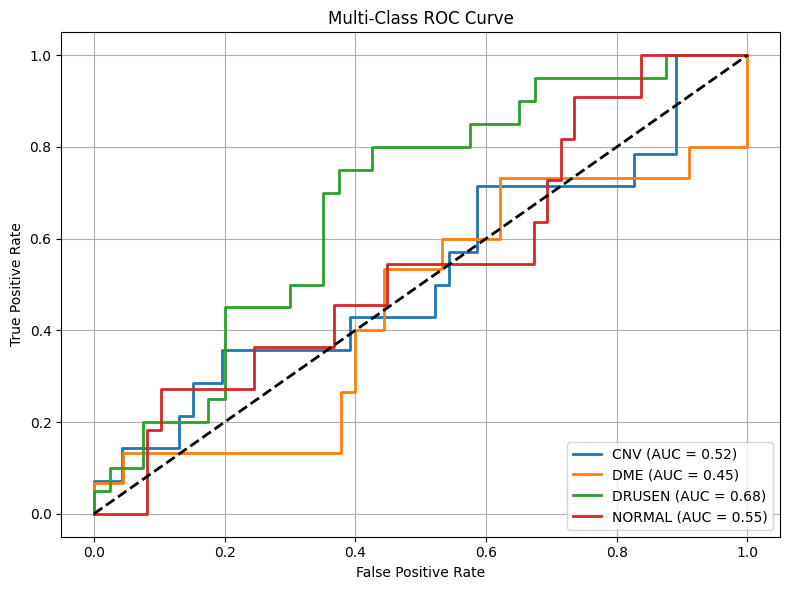

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_train_bin = lb.transform(y_train)

ovr_svm = OneVsRestClassifier(SVC(kernel='rbf', C=1, gamma='scale', probability=True))
ovr_svm.fit(X_train, y_train_bin)

y_score = ovr_svm.decision_function(X_test)

n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('svm', SVC(kernel='rbf', class_weight='balanced'))
])

param_grid = {
    'pca__n_components': [20, 50, 100],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'pca__n_components': 20, 'svm__C': 10, 'svm__gamma': 0.1}


In [ ]:
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
svm_rbf = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced')  # rbf based on proposal

In [ ]:
svm_rbf.fit(X_train_pca, y_train)# train SVM

SVC(C=10, class_weight='balanced')

In [ ]:
y_pred = svm_rbf.predict(X_test_pca)

In [ ]:
# accuracy test

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.2167


Confusion Matrix:
[[10  3  1  0]
 [11  2  0  2]
 [15  4  0  1]
 [ 9  1  0  1]]


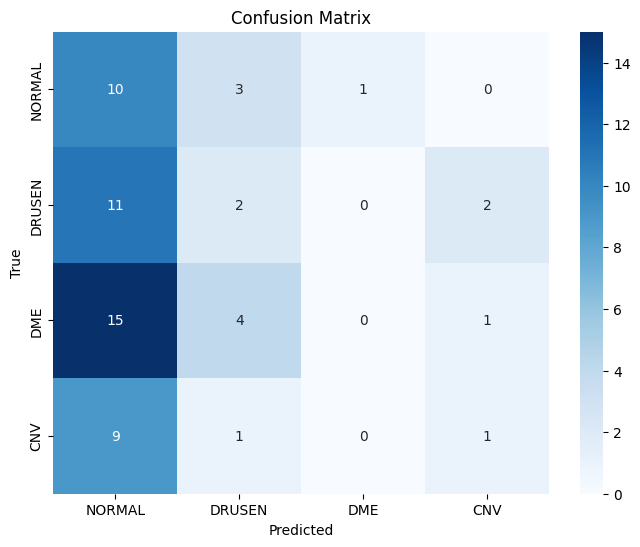

In [ ]:
# confusion matrix test

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=diseases, yticklabels=diseases)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, target_names=diseases)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.22      0.71      0.34        14
      DRUSEN       0.20      0.13      0.16        15
         DME       0.00      0.00      0.00        20
         CNV       0.25      0.09      0.13        11

    accuracy                           0.22        60
   macro avg       0.17      0.23      0.16        60
weighted avg       0.15      0.22      0.14        60



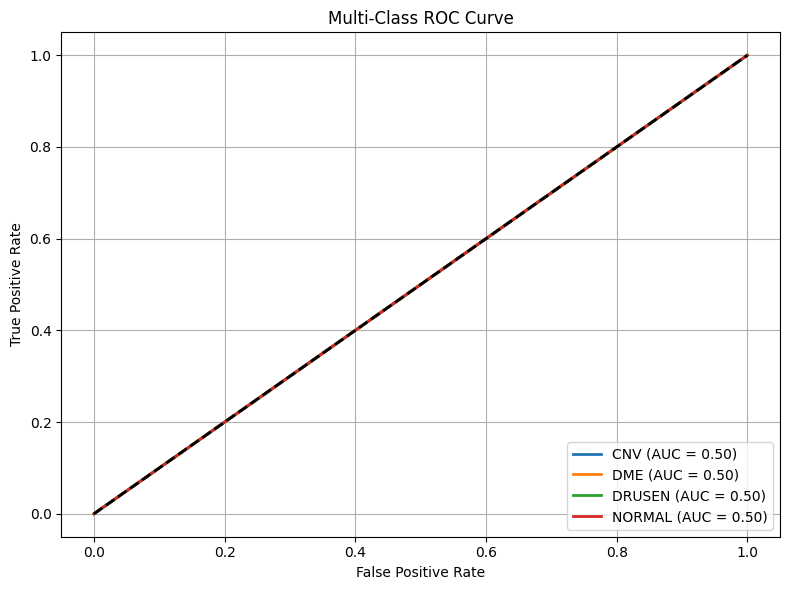

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_train_bin = lb.transform(y_train)

ovr_svm = OneVsRestClassifier(SVC(kernel='rbf', C=1, gamma=0.001, probability=True))
ovr_svm.fit(X_train, y_train_bin)

y_score = ovr_svm.decision_function(X_test)

n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()